In [562]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import seaborn as sns

from sklearn.metrics import mean_squared_error as mse_score

import mxnet as mx
import mxnet.gluon as gluon
import mxnet.gluon.nn as nn

from model import LSTMExogModel
import utils
import train
import data
from models.tcn import TCN, TCN2

import warnings
warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload 2
%matplotlib notebook

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Train TCN on only last output in sequence

In [59]:
class Combine(gluon.Block):
    def __init__(self, tcn, prefix=None):
        super(Combine, self).__init__(prefix=prefix)
        with self.name_scope():
            self.tcn = tcn
#             self.out = gluon.nn.Dense(output_seq_len)
            self.out = gluon.nn.Conv1D(1, 1)
#             self.bn = gluon.nn.BatchNorm()
        
    def forward(self, inputs):
        if isinstance(inputs, mx.nd.NDArray):
            data = inputs
            exog = None
        elif isinstance(inputs, tuple) or isinstance(inputs, list):
            assert len(inputs) == 2, \
                "Model only supports input tuples of length 2, got %d" % len(inputs)
            data, exog = inputs
        else:
            raise Exception(type(inputs))
        tcn_out = self.tcn.forward(data)
        if exog is not None:
            combined = mx.nd.concat(tcn_out, inputs[1], dim=2)
        else:
            combined = tcn_out
#         print(combined.shape)
        return self.out(combined.transpose((0, 2, 1)))

In [430]:
seq = data._gen_stationary(100, [0.3, 0.4], 10, 0.5)
seq.shape

(100,)

In [343]:
ds = data.PeriodicExogDataset(1000, 1, period=10, lam=0.6)

In [344]:
a, b = ds[9]

In [345]:
a.shape

(1000, 1)

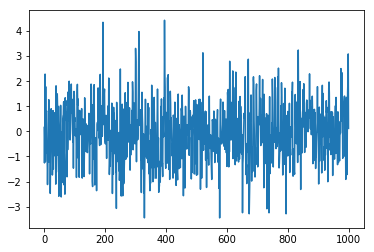

In [346]:
plt.plot(a.asnumpy())
plt.plot(np.arange(b.shape[0]), b.asnumpy())

In [348]:
# batch_size = 64
# input_seq_len = 100  # experiment with this number!!
# output_seq_len = 1
# num_layers = 1
# feature_dim = 1
# learning_rate = 0.001
# channel_list = [10, 10]

# tcn = TCN2(channel_list, feature_dim, input_seq_len, output_seq_len)
# model = Combine(tcn)
# model = TCN(channel_list, feature_dim, input_seq_len, output_seq_len)
# model.collect_params().initialize(mx.init.Xavier(), ctx=mx.cpu())

# loss = gluon.loss.L2Loss()
# trainer = gluon.Trainer(model.collect_params(), 'adam', {'learning_rate': learning_rate})

# datasets = {'train': data.GenSequenceFullDataset(input_seq_len, output_seq_len, return_sequences=False, spacing=15, lam=0.6),
#             'valid': data.GenSequenceFullDataset(input_seq_len, output_seq_len, return_sequences=False, spacing=15, lam=0.6)}
# loaders = {'train': gluon.data.DataLoader(datasets['train'], batch_size=batch_size, last_batch='discard'),
#            'valid': gluon.data.DataLoader(datasets['valid'], batch_size=batch_size, last_batch='discard')}

# train.train_epochs_tcn(model, loaders, loss, trainer, num_epochs=20, log_interval=5, ctx=[mx.cpu()])

In [565]:
batch_size = 64
input_seq_len = 100  # experiment with this number!!
ar_coefs = np.random.random(10) / 10
output_seq_len = 1
num_layers = 1
feature_dim = 1
learning_rate = 0.001
kernel_size = 4
channel_list = [5, 5, 5, 5, 5]

model = TCN(channel_list, feature_dim, input_seq_len, output_seq_len, kernel_size=kernel_size)
model.collect_params().initialize(mx.init.Xavier(), ctx=mx.cpu())

loss = gluon.loss.L2Loss()
trainer = gluon.Trainer(model.collect_params(), 'adam', {'learning_rate': learning_rate})

train_seq = seq = data._gen_stationary(10000, ar_coefs, 50, 0.5)
valid_seq = seq = data._gen_stationary(5000, ar_coefs, 50, 0.5)
datasets = {'train': data.TSArrayDataset(train_seq, input_seq_len),
            'valid': data.TSArrayDataset(valid_seq, input_seq_len)}
loaders = {'train': gluon.data.DataLoader(datasets['train'], batch_size=batch_size, last_batch='discard'),
           'valid': gluon.data.DataLoader(datasets['valid'], batch_size=batch_size, last_batch='discard')}

train.train_epochs_tcn(model, loaders, loss, trainer, num_epochs=20, log_interval=5, ctx=[mx.cpu()])

[Epoch 5] train loss = 1.052
[Epoch 10] train loss = 0.679
[Epoch 15] train loss = 0.613
[Epoch 20] train loss = 0.572


In [569]:
trainer = gluon.Trainer(model.collect_params(), 'adam', {'learning_rate': 0.001})
train.train_epochs_tcn(model, loaders, loss, trainer, num_epochs=10, log_interval=5, ctx=[mx.cpu()])

[Epoch 5] train loss = 0.545
[Epoch 10] train loss = 0.524


In [570]:
pred_steps = 100
pred_ds = data.TSArrayDataset(valid_seq, input_seq_len, out_seq_len=pred_steps)
loader = gluon.data.DataLoader(pred_ds, batch_size=batch_size, last_batch='discard')
predict_input, predict_target = next(iter(loader))

In [571]:
pred_outputs = model.predict_dynamic(predict_input, pred_steps)

<IPython.core.display.Javascript object>


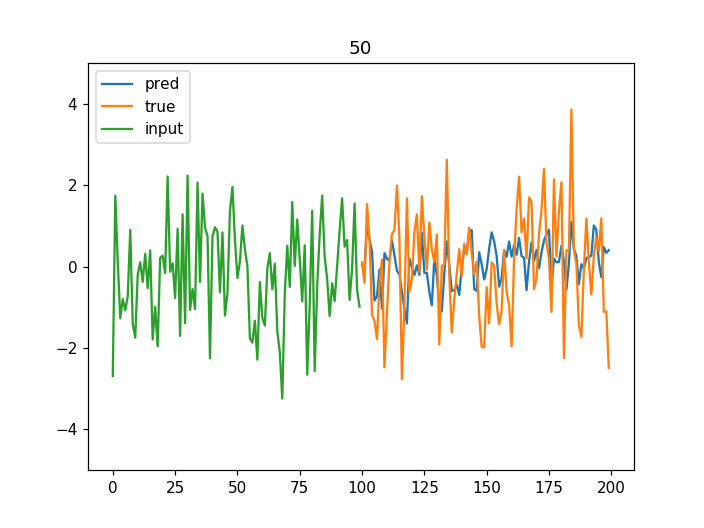

In [577]:
idx = np.random.randint(batch_size)
# idx = 26
fig, ax = plt.subplots()
ax.plot(np.arange(input_seq_len, input_seq_len + pred_steps), pred_outputs[idx].asnumpy().ravel(), label='pred')
# ax.plot(np.arange(input_seq_len, input_seq_len + pred_steps), t_outputs[idx].asnumpy().ravel(), label='pred_tcn')
ax.plot(np.arange(input_seq_len, input_seq_len + pred_steps), predict_target[idx].asnumpy().ravel(), label='true')
ax.plot(np.arange(input_seq_len), predict_input[idx].asnumpy().ravel(), label='input')
# ax.plot(np.arange(input_seq_len, input_seq_len + pred_steps), exog_input[idx].asnumpy().ravel())
ax.set_title(idx)
ax.set_ylim(-5, 5)
ax.legend();

<IPython.core.display.Javascript object>


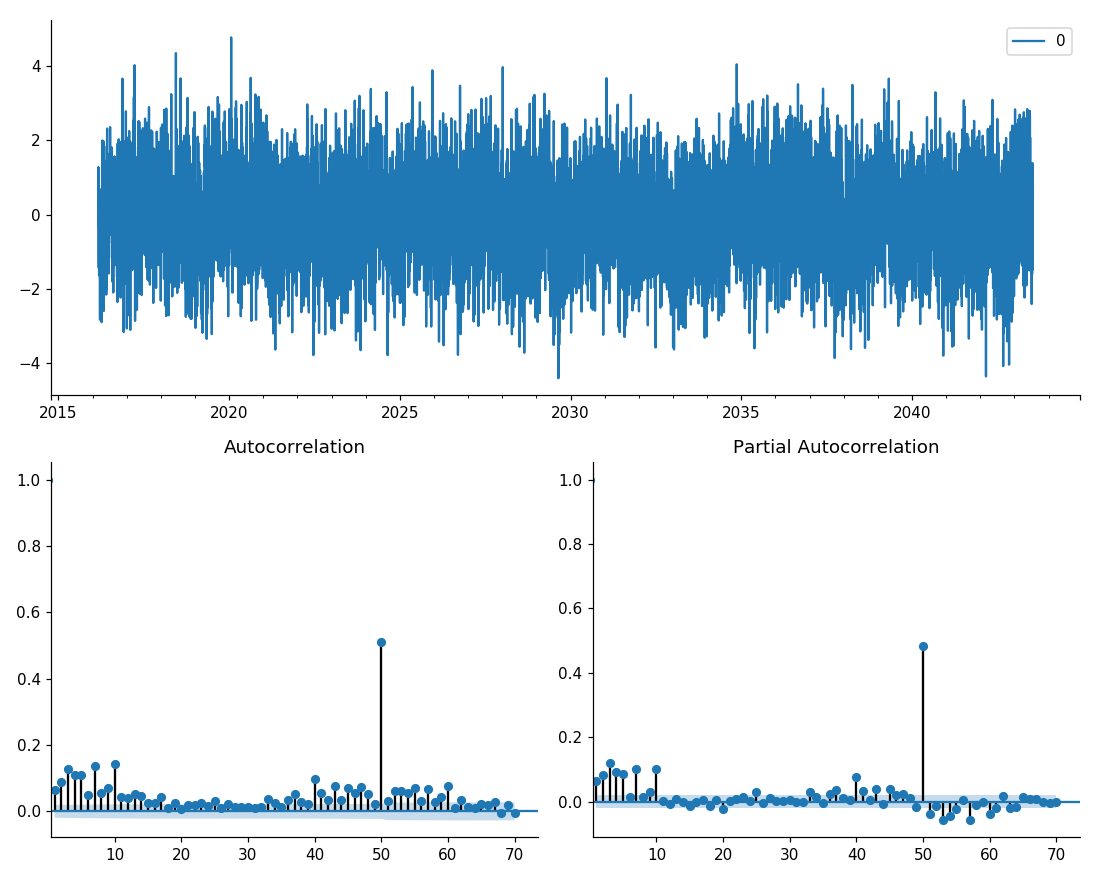

(<matplotlib.axes._subplots.AxesSubplot at 0x1c16cbfcc0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1c16da16d8>)

In [546]:
utils.tsplot(make_index(train_seq.asnumpy()), lags=70)

In [550]:
arima = smt.SARIMAX(make_index(train_seq.asnumpy()), order=(10, 0, 0), seasonal_order=(1, 0, 0, 50))
res = arima.fit()

In [551]:
0.5 * np.mean((res.predict() - train_seq.asnumpy())**2)

0.50631356877525435

<IPython.core.display.Javascript object>


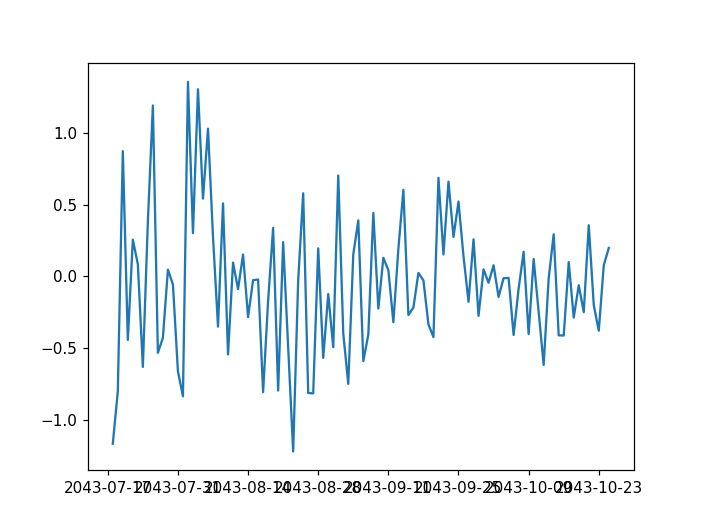

In [552]:
fig, ax = plt.subplots()
ax.plot(res.forecast(100))

In [519]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      0   No. Observations:                10000
Model:               SARIMAX(2, 0, 0)   Log Likelihood              -14321.968
Date:                Mon, 16 Apr 2018   AIC                          28649.936
Time:                        14:50:36   BIC                          28671.567
Sample:                    03-01-2016   HQIC                         28657.258
                         - 07-17-2043                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0660      0.010      6.707      0.000       0.047       0.085
ar.L2          0.0664      0.010      6.609      0.000       0.047       0.086
sigma2         1.0269      0.014     72.155      0.000       0.999       1.055
===================================================================================
Ljung-Box (Q):                      306.02   Jarque-Bera (JB):                 4.54
Prob(Q):                              0.00   Prob(JB):                         0.10
Heteroskedasticity (H):               1.05   Skew:                             0.03
Prob(H) (two-sided):                  0.20   Kurtosis:                         3.08
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Train TCN using entire prediction sequence

In [33]:
batch_size = 64
input_seq_len = 100  # experiment with this number!!
output_seq_len = 1
num_layers = 1
feature_dim = 1
learning_rate = 0.001
channel_list = [10]
train_sequences=True

tcn = TCN(channel_list, feature_dim, input_seq_len, output_seq_len, train_sequences=train_sequences)

# collect all NDArrays associated with each layer and initialize them
tcn.collect_params().initialize(mx.init.Xavier(), ctx=mx.cpu())

loss = gluon.loss.L2Loss()
trainer = gluon.Trainer(tcn.collect_params(), 'adam', {'learning_rate': learning_rate})

datasets = {'train': data.GenSequenceFullDataset(input_seq_len, output_seq_len, 
                                                 return_sequences=train_sequences, spacing=15, lam=0.0),
            'valid': data.GenSequenceFullDataset(input_seq_len, output_seq_len, 
                                                 return_sequences=train_sequences, spacing=15, lam=0.0)}
loaders = {'train': gluon.data.DataLoader(datasets['train'], batch_size=batch_size, last_batch='discard'),
           'valid': gluon.data.DataLoader(datasets['valid'], batch_size=batch_size, last_batch='discard')}

train.train_epochs_tcn(tcn, loaders, loss, trainer, num_epochs=20, log_interval=5, ctx=[mx.cpu()])

[Epoch 5] train loss = 4.499
[Epoch 10] train loss = 1.739
[Epoch 15] train loss = 1.408
[Epoch 20] train loss = 1.298


In [34]:
trainer = gluon.Trainer(tcn.collect_params(), 'adam', {'learning_rate': 0.001})
train.train_epochs_tcn(tcn, loaders, loss, trainer, num_epochs=20, log_interval=5, ctx=[mx.cpu()])

[Epoch 5] train loss = 1.074
[Epoch 10] train loss = 1.027
[Epoch 15] train loss = 0.988
[Epoch 20] train loss = 0.982


In [36]:
pred_steps = 300
pred_ds = data.GenSequenceFullDataset(input_seq_len, pred_steps, 
                                      return_sequences=train_sequences, spacing=15, lam=0.0)
loader = gluon.data.DataLoader(pred_ds, batch_size=batch_size, last_batch='discard')
(predict_input, exog_input), predict_target = next(iter(loader))

In [597]:
pred_outputs = tcn.predict_dynamic(predict_input, pred_steps, exog_input=exog_input)

<IPython.core.display.Javascript object>


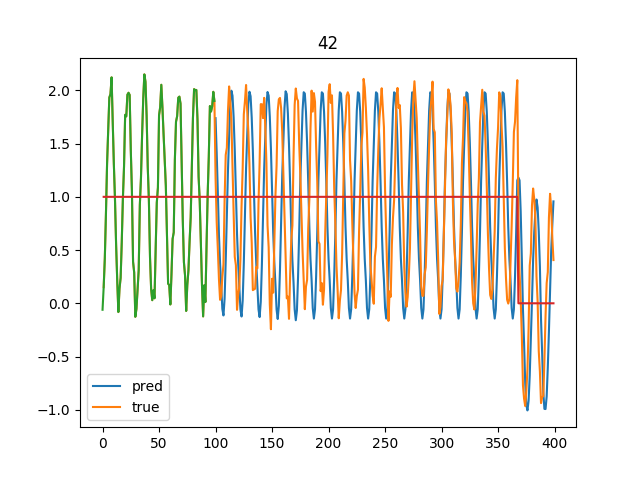

In [610]:
idx = np.random.randint(batch_size)
fig, ax = plt.subplots()
ax.plot(np.arange(input_seq_len, input_seq_len + pred_steps), pred_outputs[idx].asnumpy().ravel(), label='pred')
ax.plot(np.arange(1, input_seq_len + pred_steps), predict_target[idx].asnumpy().ravel(), label='true')
ax.plot(np.arange(input_seq_len), predict_input[idx].asnumpy().ravel())
ax.plot(np.arange(1, input_seq_len + pred_steps), exog_input[idx].asnumpy().ravel())
ax.set_title(idx)
ax.legend();